# NIPBL
[Cornelia de Lange syndrome-1 (CDLS1)](https://omim.org/entry/122470) is caused by heterozygous mutation in the NIPBL gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


## NIPBL
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NIPBL.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'NIPBL'
mane_tx_id = 'NM_133433.4'
mane_protein_id = 'NP_597677.2' # nipped-B-like protein isoform A
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.24' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    cdls1_phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=cdls1_phenopackets, 
    cohort_creator=cohort_creator,
)

qc.summarize()

Individuals Processed: 100%|██████████| 60/60 [00:08<00:00,  7.13 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
46,Synophrys
42,Global developmental delay
42,Long eyelashes
39,Microcephaly
39,Intrauterine growth retardation
39,Hirsutism
37,Long philtrum
36,Highly arched eyebrow
36,Thin upper lip vermilion
34,Downturned corners of mouth


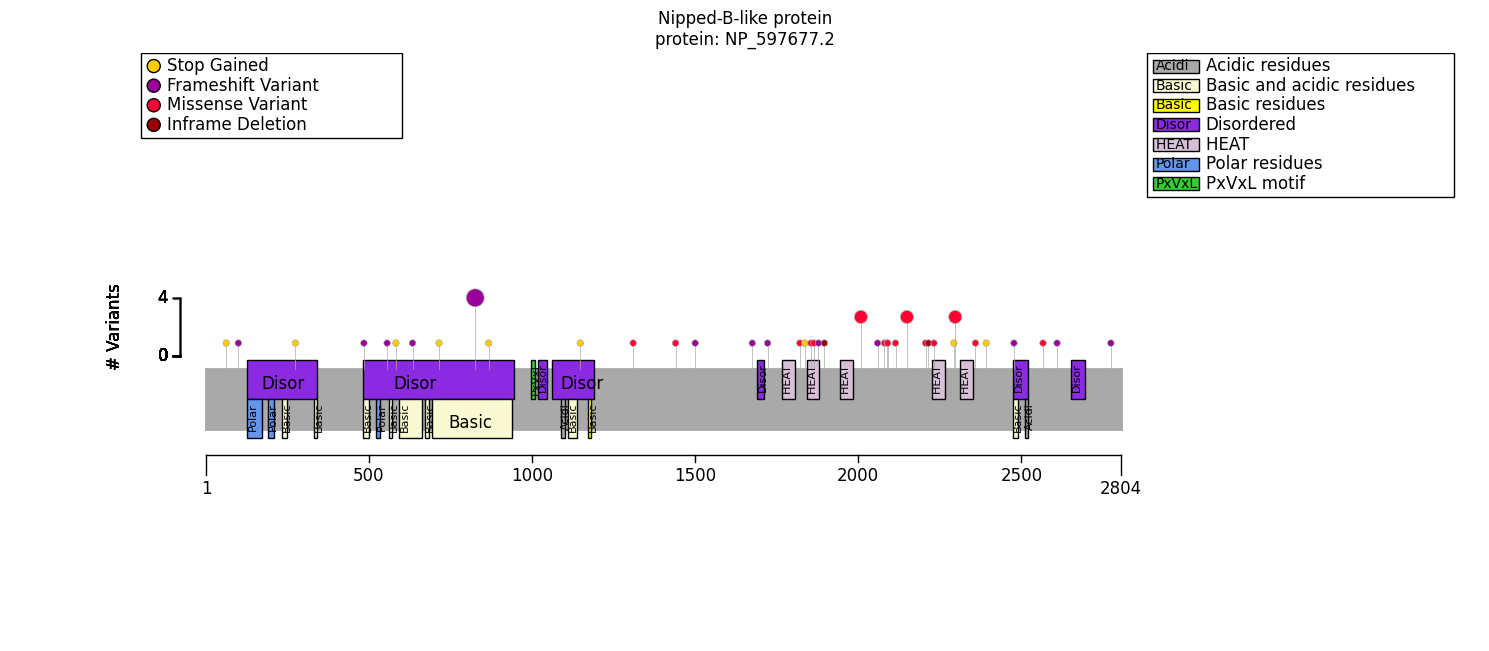

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

nipbl_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
nipbl_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
1,Disordered,Region,129 - 340,p.Gln276Ter
0,Polar residues,Compositional bias,129 - 173,
0,Polar residues,Compositional bias,192 - 208,
0,Basic and acidic residues,Compositional bias,235 - 249,
0,Basic and acidic residues,Compositional bias,332 - 340,
10,Disordered,Region,483 - 946,p.Ser635TyrfsTer3; p.Glu487Ter; p.Thr558LeufsTer7; p.Arg827GlyfsTer2; p.Arg827GlyfsTer20; p.Asp584GlufsTer11; p.Arg868Ter; p.Gln716Ter
1,Basic and acidic residues,Compositional bias,483 - 500,p.Glu487Ter
0,Polar residues,Compositional bias,524 - 534,
0,Basic and acidic residues,Compositional bias,563 - 572,
1,Basic and acidic residues,Compositional bias,594 - 663,p.Ser635TyrfsTer3


# Genotype Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

missense = variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="missense",
    b_label="other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,19
"Skipping ""general"" level terms",69
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),158


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense,other,Corrected p values,p values
Small hand [HP:0200055],3/15 (20%),24/37 (65%),0.454741,0.005288
Hearing impairment [HP:0000365],3/13 (23%),13/20 (65%),1.000000,0.032361
Depressed nasal bridge [HP:0005280],6/13 (46%),24/30 (80%),1.000000,0.036714
Microcephaly [HP:0000252],9/13 (69%),30/33 (91%),1.000000,0.086669
Myopia [HP:0000545],0/9 (0%),5/17 (29%),1.000000,0.128550
...,...,...,...,...
Abnormal external nose morphology [HP:0010938],9/9 (100%),26/26 (100%),1.000000,1.000000
Abnormality of upper lip vermillion [HP:0011339],9/9 (100%),27/27 (100%),1.000000,1.000000
Thin vermilion border [HP:0000233],9/9 (100%),27/27 (100%),1.000000,1.000000
Decreased head circumference [HP:0040195],9/9 (100%),30/30 (100%),1.000000,1.000000


In [10]:
from gpsea.analysis.predicate import protein_feature

disordered = protein_feature(feature_id="Disordered", protein_metadata=protein_meta)
disordered_clf = missense_predicate = monoallelic_classifier (
    a_predicate=disordered,
    b_predicate=~disordered,
    a_label="disordered",
    b_label="other"
)
disordered_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=disordered_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=disordered_result)

Allele group,disordered,other,Corrected p values,p values
Intrauterine growth retardation [HP:0001511],10/10 (100%),29/42 (69%),1.0,0.050161
Curly eyelashes [HP:0007665],6/9 (67%),27/30 (90%),1.0,0.122513
Single transverse palmar crease [HP:0000954],5/5 (100%),15/27 (56%),1.0,0.130085
Limited elbow extension [HP:0001377],4/6 (67%),8/28 (29%),1.0,0.154142
Short stature [HP:0004322],4/6 (67%),29/32 (91%),1.0,0.168956
...,...,...,...,...
Abnormal brain morphology [HP:0012443],9/9 (100%),31/31 (100%),1.0,1.000000
Abnormal upper lip morphology [HP:0000177],9/9 (100%),34/34 (100%),1.0,1.000000
Abnormal lip morphology [HP:0000159],9/9 (100%),34/34 (100%),1.0,1.000000
Abnormal nasal morphology [HP:0005105],9/9 (100%),35/35 (100%),1.0,1.000000


In [11]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Clinodactyly [HP:0030084],6/12 (50%),15/17 (88%),1.0,0.038194
Finger clinodactyly [HP:0040019],5/11 (45%),13/15 (87%),1.0,0.038444
Intrauterine growth retardation [HP:0001511],17/19 (89%),18/28 (64%),1.0,0.087457
Long eyelashes [HP:0000527],10/12 (83%),24/24 (100%),1.0,0.104762
Micrognathia [HP:0000347],13/18 (72%),13/27 (48%),1.0,0.134109
...,...,...,...,...
Deviation of finger [HP:0004097],8/8 (100%),16/16 (100%),1.0,1.000000
Abnormal finger morphology [HP:0001167],8/8 (100%),16/16 (100%),1.0,1.000000
Abnormal external nose morphology [HP:0010938],8/8 (100%),21/21 (100%),1.0,1.000000
Short stature [HP:0004322],9/11 (82%),17/20 (85%),1.0,1.000000


# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result
    ),
    GPAnalysisResultSummary.from_mono(
        result=disordered_result
    ),
    GPAnalysisResultSummary.from_mono(
        result=mf_result
    ),
)

caption = "No statistically significant genotype-phenotype correlation identified."

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense,other,86,0
Genotype (A),Genotype (B),Tests performed,Significant tests
disordered,other,86,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,81,0


In [14]:
summarizer.process_latex(report=report, protein_fig=nipbl_fig)

Figure saved to ../../supplement/img/NIPBL_protein_diagram-draft.pdf
Output to ../../supplement/tex/NIPBL_summary_draft.tex
